In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile

In [ ]:
# Select the file and load the path
file_path = '/content/drive/MyDrive/project/cnn/Concrete Crack Images for Classification/data'

SEED = 345
IMG_SIZE = (160,160)
train_dataset = tf.keras.utils.image_dataset_from_directory(
  file_path,
  validation_split=0.3,
  subset="training",
  image_size=IMG_SIZE,
  seed=SEED,
  batch_size=50)

val_dataset = tf.keras.utils.image_dataset_from_directory(
  file_path,
  validation_split=0.2,
  subset="validation",
  image_size=IMG_SIZE,
  seed=SEED,
  batch_size=50)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


In [ ]:
# Check class names
class_names = train_dataset.class_names
class_names

['Negative', 'Positive']

tf.Tensor(
[0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0
 0 1 1 1 1 1 0 1 0 0 0 0 1], shape=(50,), dtype=int32)


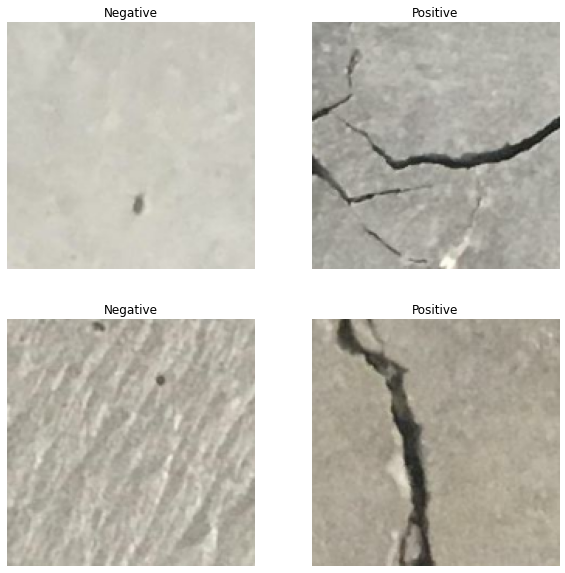

In [ ]:
# Display some images
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
  #To check the labels shape
  print(labels)
  for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
#cardinality = size of set
val_batches = tf.data.experimental.cardinality(val_dataset)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=160>

In [ ]:
test_dataset = val_dataset.take(val_batches // 5) # divide by 5 to extract 20% off
validation_dataset = val_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 128
Number of test batches: 32


In [ ]:
#To create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset_pf = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential()
# data_augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
# data_augmentation.add(tf.keras.layers.RandomRotation(0.2))

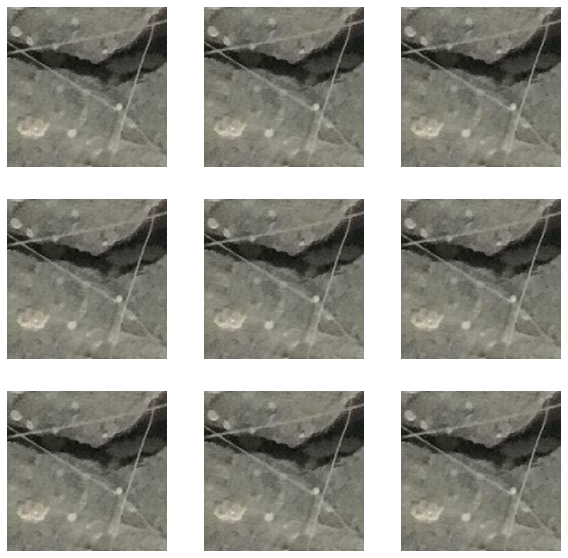

In [ ]:
#Show exmaple of applied image augmentation
for image,labels in train_dataset_pf.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#We will make use of the method provided in the pretrained model object to rescale input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
IMG_SHAPE

(160, 160, 3)

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
#Create our own classification layer
class_names = train_dataset.class_names
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
output_dense = tf.keras.layers.Dense(len(class_names),activation='softmax')

In [ ]:
# Use functional API to create the entire model (augmentation + preprocess + CNN)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = global_avg_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = output_dense(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
#Compile model
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

In [ ]:
EPOCHS = 5
history = model.fit(train_dataset_pf,validation_data=validation_dataset_pf,epochs=EPOCHS)

Epoch 1/5
560/560 [==============================] - 2514s 4s/step - loss: 0.1097 - accuracy: 0.9656 - val_loss: 0.0234 - val_accuracy: 0.9945
Epoch 2/5
560/560 [==============================] - 585s 1s/step - loss: 0.0161 - accuracy: 0.9961 - val_loss: 0.0136 - val_accuracy: 0.9958
Epoch 3/5
560/560 [==============================] - 579s 1s/step - loss: 0.0104 - accuracy: 0.9975 - val_loss: 0.0104 - val_accuracy: 0.9966
Epoch 4/5
560/560 [==============================] - 589s 1s/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.0087 - val_accuracy: 0.9973
Epoch 5/5
560/560 [==============================] - 596s 1s/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0079 - val_accuracy: 0.9972


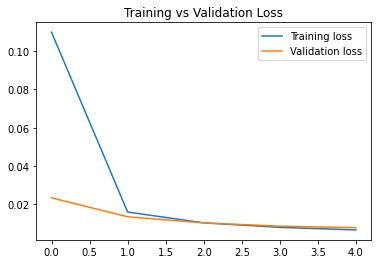

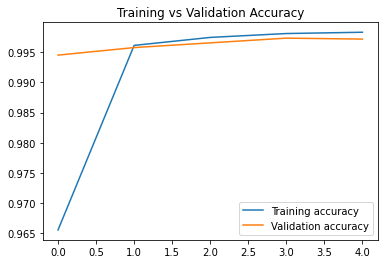

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training vs validation accuracy
import matplotlib.pyplot as plt

training_loss = history.history['loss']
val_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = history.epoch

plt.plot(epochs,training_loss,label='Training loss',)
plt.plot(epochs,val_loss,label='Validation loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.figure()

plt.plot(epochs,training_accuracy,label='Training accuracy')
plt.plot(epochs,val_accuracy,label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
#Evaluate with test dataset
test_loss,test_accuracy = model.evaluate(test_dataset_pf)

print('------------------------Test Result----------------------------')
print(f'Loss = {test_loss}')
print(f'Accuracy = {test_accuracy}')

32/32 [==============================] - 31s 956ms/step - loss: 0.0061 - accuracy: 0.9987
------------------------Test Result----------------------------
Loss = 0.006065215449780226
Accuracy = 0.9987499713897705
